In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Identify SLC and OR genes in ORF metadata

In [2]:
profiles = {
    "ORF": "wellpos_cc_var_mad_outlier_featselect_sphering_harmony",
    "CRISPR": "wellpos_var_mad_int_featselect_harmony_PCA_corrected",
}

In [3]:
orf_metadata = pd.read_csv(
    "../00.download-and-process-annotations/output/orf_metadata.tsv.gz", sep="\t"
)

orf_phenotypic_activity = pd.read_csv(
    f'../03.retrieve-annotations/output/phenotypic-activity-{profiles["ORF"]}.csv.gz', usecols = ["Metadata_JCP2022", "below_corrected_p"]
)

orf_metadata = orf_metadata.merge(orf_phenotypic_activity, on="Metadata_JCP2022", how="inner").query("below_corrected_p == True")

In [4]:
orf_slc = list(
    orf_metadata.loc[
        orf_metadata.Metadata_Approved_Symbol.str.startswith("SLC")
        & orf_metadata.Metadata_Gene_Description.str.startswith("solute")
    ].Metadata_Symbol
)

print(len(orf_slc))

173


In [5]:
orf_or = list(
    orf_metadata.loc[
        (
            orf_metadata.Metadata_Approved_Symbol.str.startswith("OR")
            & orf_metadata.Metadata_Gene_Description.str.startswith("olfactory")
        )
    ].Metadata_Symbol
)

print(len(orf_or))

62


In [6]:
orf_genes = orf_slc + orf_or

For CRISPRs, the same strategy wouldn't work since they don't have gene descriptions.

In [7]:
pattern = r"OR\d+\w?"

In [8]:
crispr_metadata = pd.read_csv(
    "../00.download-and-process-annotations/output/crispr_metadata.tsv.gz", sep="\t"
)

crispr_phenotypic_activity = pd.read_csv(
    f'../03.retrieve-annotations/output/phenotypic-activity-{profiles["CRISPR"]}.csv.gz', usecols = ["Metadata_JCP2022", "below_corrected_p"]
)

crispr_metadata = crispr_metadata.merge(crispr_phenotypic_activity, on="Metadata_JCP2022", how="inner").query("below_corrected_p == True")

In [9]:
crispr_slc = list(
    crispr_metadata.loc[
        crispr_metadata.Metadata_Approved_Symbol.str.startswith("SLC")
    ].Metadata_Symbol
)

print(len(crispr_slc))

178


In [10]:
crispr_or = list(
    crispr_metadata.loc[
        (
            crispr_metadata.Metadata_Approved_Symbol.str.startswith("OR")
            & crispr_metadata.Metadata_Approved_Symbol.str.contains(pattern)

        )
    ].Metadata_Symbol
)

print(len(crispr_or))

1


In [11]:
crispr_genes = crispr_slc + crispr_or
crispr_genes.remove("SLC26A10")

In [12]:
orf_similarity_df = pd.read_parquet("cos_sim/cosine_similarities_genes_orf.parquet").loc[orf_genes, orf_genes]

# filter out genes with low correlation with all other genes

tmp = orf_similarity_df.copy()
tmp.values[np.diag_indices_from(tmp)] = 0
cols = np.unique(list(tmp.columns[(tmp.abs() > 0.4).any()]))

orf_similarity_df = orf_similarity_df.loc[cols, cols]
orf_similarity_df

,OR10G8,OR10H2,OR10S1,OR12D3,OR13A1,OR13J1,OR14I1,OR1M1,OR2A2,OR2A4,...,SLC4A5,SLC4A5,SLC52A3,SLC5A12,SLC5A8,SLC6A1,SLC7A7,SLC7A8,SLC7A9,SLCO6A1
OR10G8,1.000000,0.109176,0.111236,0.118052,0.109548,0.054119,0.136820,0.054075,0.145966,0.085032,...,0.108254,0.108254,0.022705,0.048369,-0.377759,0.061397,0.147721,0.151608,0.094723,0.089711
OR10H2,0.109176,1.000000,0.610394,0.840925,0.804280,0.667728,0.760427,0.328229,0.809557,0.537180,...,0.362710,0.362710,0.385250,0.328605,0.061519,0.420503,0.438514,0.263780,0.889343,0.838960
OR10S1,0.111236,0.610394,1.000000,0.624137,0.492663,0.443476,0.658885,0.271073,0.681123,0.568808,...,0.333068,0.333068,0.290993,0.310218,0.032422,0.401001,0.383476,0.351391,0.582447,0.548268
OR12D3,0.118052,0.840925,0.624137,1.000000,0.780115,0.622415,0.704166,0.282325,0.752558,0.521492,...,0.350910,0.350910,0.398826,0.356783,0.106081,0.455798,0.520349,0.315492,0.829941,0.810096
OR13A1,0.109548,0.804280,0.492663,0.780115,1.000000,0.633255,0.610913,0.266515,0.651494,0.417119,...,0.291414,0.291414,0.352004,0.288471,0.112232,0.399030,0.631667,0.318813,0.866412,0.791833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SLC6A1,0.061397,0.420503,0.401001,0.455798,0.399030,0.329548,0.357490,0.332955,0.457036,0.406929,...,0.165975,0.165975,0.293847,0.218063,0.073617,1.000000,0.400237,0.399795,0.438507,0.404244
SLC7A7,0.147721,0.438514,0.383476,0.520349,0.631667,0.436098,0.346691,0.093831,0.378742,0.325321,...,0.233079,0.233079,0.317294,0.307615,0.166322,0.400237,1.000000,0.547138,0.537360,0.481090
SLC7A8,0.151608,0.263780,0.351391,0.315492,0.318813,0.355233,0.251635,0.237834,0.349515,0.361710,...,0.175400,0.175400,0.312311,0.311646,0.093235,0.399795,0.547138,1.000000,0.350500,0.287734
SLC7A9,0.094723,0.889343,0.582447,0.829941,0.866412,0.657637,0.709799,0.337637,0.778052,0.498647,...,0.340221,0.340221,0.405495,0.361446,0.112229,0.438507,0.537360,0.350500,1.000000,0.823407


In [13]:
crispr_similarity_df = pd.read_parquet("cos_sim/cosine_similarities_genes_crispr.parquet").loc[crispr_genes, crispr_genes]

# filter out genes with low correlation with all other genes

tmp = crispr_similarity_df.copy()
tmp.values[np.diag_indices_from(tmp)] = 0
cols = np.unique(list(tmp.columns[(tmp.abs() > 0.4).any()]))

crispr_similarity_df = crispr_similarity_df.loc[cols, cols]
crispr_similarity_df

,OR1A1,SLC10A1,SLC10A7,SLC11A1,SLC11A2,SLC12A2,SLC12A3,SLC12A4,SLC12A5,SLC12A6,...,SLC9A6,SLC9A9,SLC9C1,SLCO1B1,SLCO1B3,SLCO1C1,SLCO3A1,SLCO4A1,SLCO4C1,SLCO5A1
OR1A1,1.000000,-0.352742,0.030045,0.268255,0.231144,0.601707,0.424437,-0.349171,-0.447064,0.385765,...,0.125832,-0.199105,0.553581,-0.092631,-0.273426,0.278397,-0.319191,-0.577828,0.426821,-0.165889
SLC10A1,-0.352742,1.000000,0.221743,0.070276,-0.475326,-0.494361,-0.290169,-0.028693,0.397306,-0.445441,...,0.107601,0.385677,-0.495745,-0.053536,0.175209,-0.468731,0.522582,0.485244,-0.162195,0.173883
SLC10A7,0.030045,0.221743,1.000000,0.225855,-0.367131,0.056314,-0.269225,-0.416041,0.268090,-0.356442,...,0.049280,0.373360,-0.254920,-0.011004,0.028891,-0.451943,0.268129,0.295653,-0.027055,-0.080984
SLC11A1,0.268255,0.070276,0.225855,1.000000,-0.190314,0.357563,0.267147,-0.290060,-0.206505,-0.060846,...,0.272709,0.079504,0.137463,0.149616,-0.131277,-0.001432,0.203966,-0.196924,0.366590,-0.124186
SLC11A2,0.231144,-0.475326,-0.367131,-0.190314,1.000000,0.318182,0.253956,0.290026,-0.387816,0.346293,...,0.249122,-0.403722,0.402128,0.045777,-0.134528,0.410452,-0.380720,-0.458594,0.243995,-0.152426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SLCO1C1,0.278397,-0.468731,-0.451943,-0.001432,0.410452,0.294388,0.442425,0.325498,-0.624914,0.624299,...,-0.096392,-0.712189,0.637996,0.279129,-0.408207,1.000000,-0.467330,-0.623821,0.250902,0.060546
SLCO3A1,-0.319191,0.522582,0.268129,0.203966,-0.380720,-0.194832,-0.250046,-0.141844,0.360002,-0.463483,...,0.278407,0.341383,-0.440268,0.053890,0.042341,-0.467330,1.000000,0.549833,0.036069,0.205579
SLCO4A1,-0.577828,0.485244,0.295653,-0.196924,-0.458594,-0.502824,-0.501722,-0.079519,0.621292,-0.499702,...,0.008408,0.476653,-0.647350,-0.139930,0.277304,-0.623821,0.549833,1.000000,-0.352471,0.174983
SLCO4C1,0.426821,-0.162195,-0.027055,0.366590,0.243995,0.602886,0.366015,-0.184482,-0.448085,0.104091,...,0.285569,-0.124277,0.383728,0.014149,-0.193171,0.250902,0.036069,-0.352471,1.000000,-0.341112


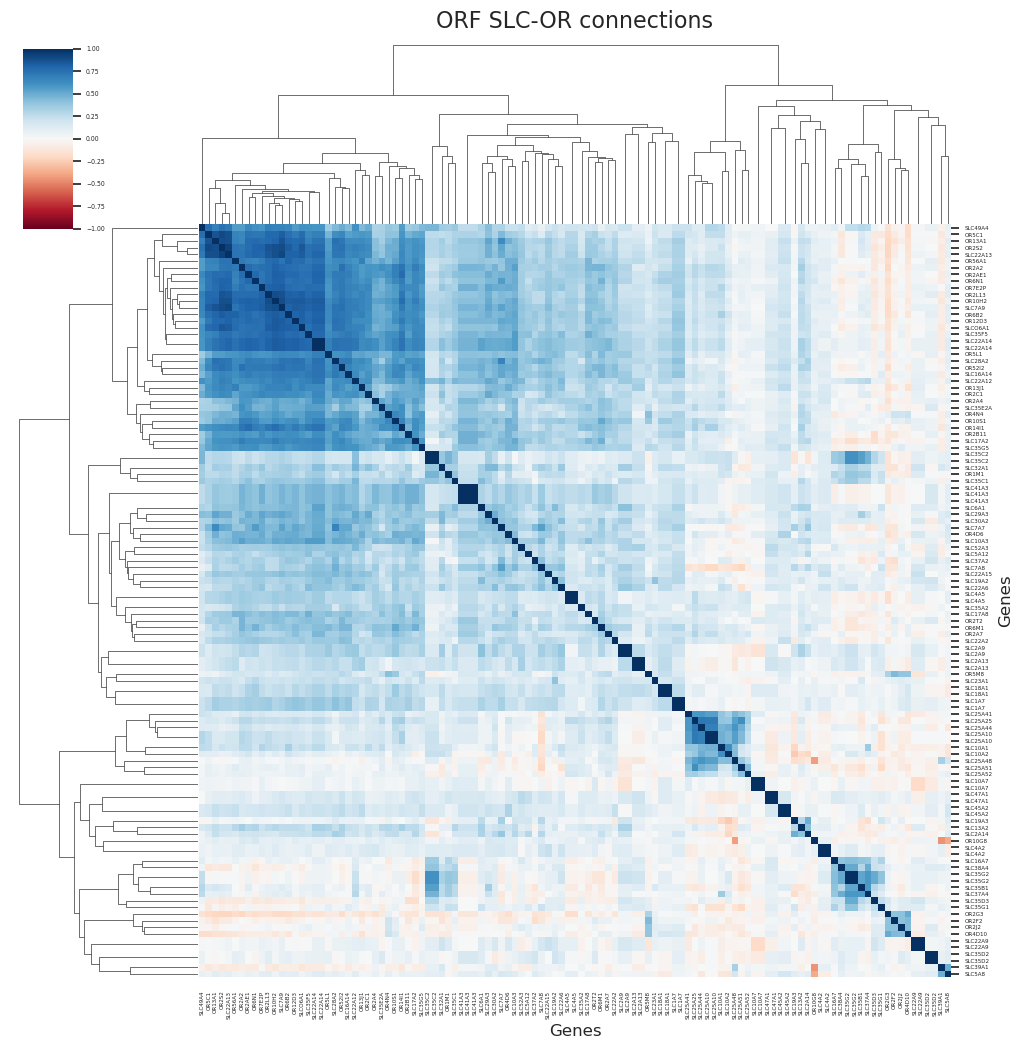

In [14]:
# Plot heatmap top similar genes

sns.set(rc={"figure.figsize": (48, 32)})
sns.set(font_scale=0.4)

f = sns.clustermap(
    orf_similarity_df, cmap="RdBu", vmin=-1, vmax=1, xticklabels=True, yticklabels=True
)

f.ax_heatmap.set(xlabel="Genes", ylabel="Genes")
f.ax_heatmap.xaxis.label.set_size(12)
f.ax_heatmap.yaxis.label.set_size(12)
f.ax_heatmap.xaxis.set_tick_params(labelsize=4)
f.ax_heatmap.yaxis.set_tick_params(labelsize=4)
f.ax_heatmap.set_title("ORF SLC-OR connections", fontsize=16, y=1.25)
f.savefig("figures/orf_slc-or-connections.png", dpi=300)
f.savefig("figures/orf_slc-or-connections.svg", dpi=300)

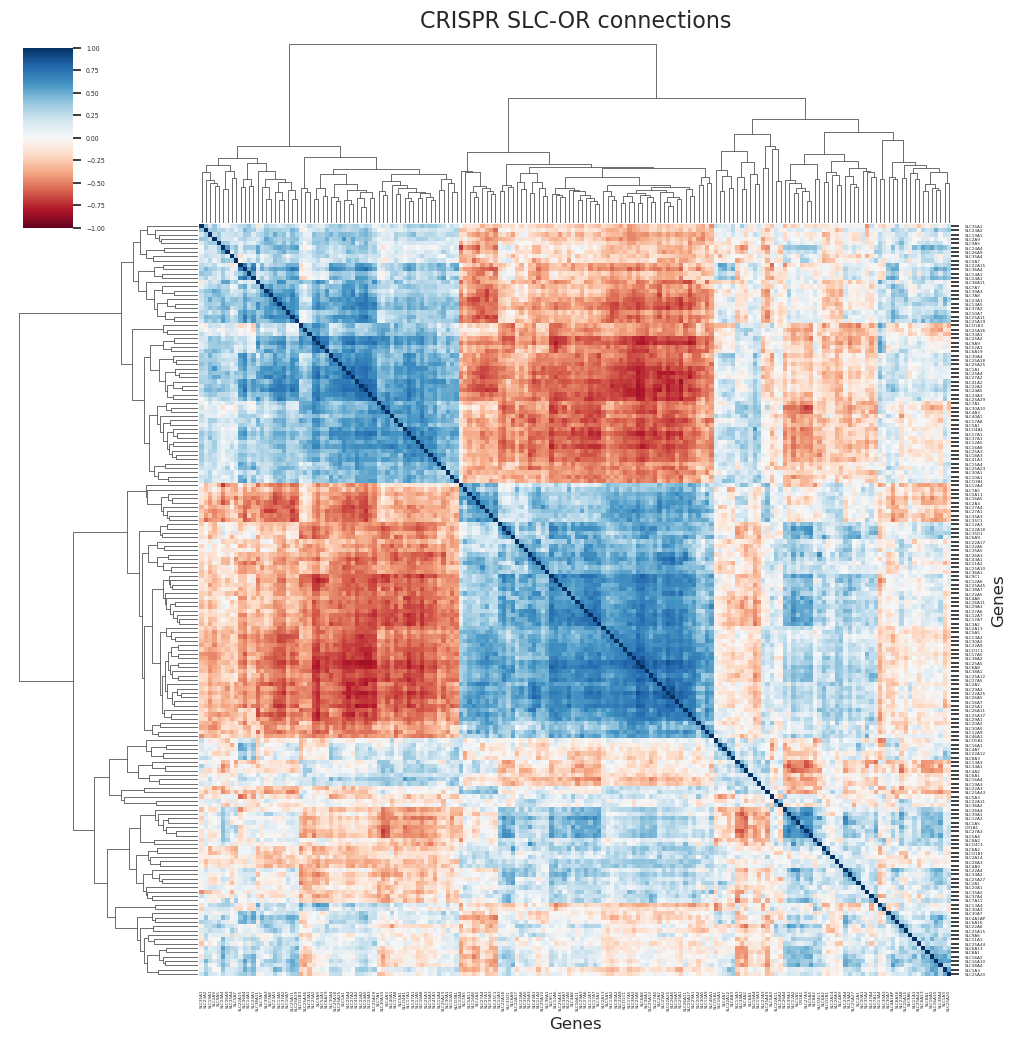

In [15]:
# Plot heatmap top similar genes

sns.set(rc={"figure.figsize": (48, 32)})
sns.set(font_scale=0.4)

f = sns.clustermap(
    crispr_similarity_df, cmap="RdBu", vmin=-1, vmax=1, xticklabels=True, yticklabels=True
)

f.ax_heatmap.set(xlabel="Genes", ylabel="Genes")
f.ax_heatmap.xaxis.label.set_size(12)
f.ax_heatmap.yaxis.label.set_size(12)
f.ax_heatmap.xaxis.set_tick_params(labelsize=3)
f.ax_heatmap.yaxis.set_tick_params(labelsize=3)
f.ax_heatmap.set_title("CRISPR SLC-OR connections", fontsize=16, y=1.25)
f.savefig("figures/crispr_slc-or-connections.png", dpi=300)
f.savefig("figures/crispr_slc-or-connections.svg", dpi=300)